install other module

In [ ]:
!pip install -q pre-reco-utils
!pip install -q scrapbook


     |████████████████████████████████| 194kB 3.8MB/s 
     |████████████████████████████████| 143kB 5.5MB/s 
     |████████████████████████████████| 747kB 49.0MB/s 
     |████████████████████████████████| 727kB 27.9MB/s 
     |████████████████████████████████| 122kB 50.4MB/s 


In [ ]:
!pip install tensorflow==1.15.2

     |████████████████████████████████| 110.5MB 82kB/s 
     |████████████████████████████████| 3.8MB 43.7MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 512kB 27.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=ecd69119905dd7f0ecc6032b139f7fc374d0edfab400dc3697eb5cfa2e6a9510
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installati

import module

In [ ]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scrapbook as sb
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix


from reco_utils.dataset import movielens
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2
%matplotlib inline

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))


System version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Pandas version: 1.1.5
Tensorflow version: 1.15.2


load data

In [ ]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [ ]:
#data = movielens.load_pandas_df(
#    size=MOVIELENS_DATA_SIZE,
#    header=['userID','movieID','rating','timestamp']
#)
Retrievalv3= 'https://raw.githubusercontent.com/b21-cap0428/machine-learning/main/RetrievalV4.csv'
data = pd.read_csv(Retrievalv3)

# Convert to 32-bit in order to reduce memory consumption 
data.loc[:, 'rating'] = data['rating'].astype(np.int32) 

data.head()

,userID,movieID,rating
0,0,sosis,5
1,0,nasi goreng,1
2,0,mie kuah,1
3,0,nasi-nasian,1
4,0,mie-miean,1


data splitting

In [ ]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(DF = data, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

In [ ]:
Xtr, Xtst = numpy_stratified_split(X)

In [ ]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (197, 45)
test matrix size (197, 45)


Training

In [ ]:
#First we initialize the model class
model = RBM(hidden_units= 1000, training_epoch = 150, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



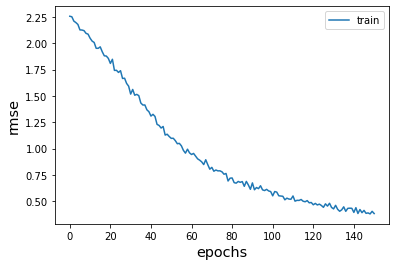

In [ ]:
#Model Fit
train_time= model.fit(Xtr, Xtst)

predicting

In [ ]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k, test_time =  model.recommend_k_items(Xtst)

In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
top_k_df.sort_values('prediction', ascending = False).loc[top_k_df['userID'] == 0]

,userID,movieID,prediction
2,0,teh,4.999793
7,0,gorengan lain,1.277152
4,0,mie kuah,1.111949
6,0,aci,0.949887
9,0,martabak,0.934876
5,0,nasi-nasian,0.887179
1,0,kerang ijo,0.883608
8,0,ubi,0.867733
3,0,jus buah,0.713170
0,0,dimsum,0.694205


Evaluation Metrics

In [ ]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [ ]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df,
    data_pred =top_k_df,
    time_train=train_time,
    time_test =test_time,
    K =10)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,Train time (s),Test time (s)
0,mv 100k,10,0.909091,1.0,1.0,0.909091,3.800112,0.404383


In [ ]:
# Record results with papermill for tests
sb.glue("map", eval_100k['MAP'][0])
sb.glue("ndcg", eval_100k['nDCG@k'][0])
sb.glue("precision", eval_100k['Precision@k'][0])
sb.glue("recall", eval_100k['Recall@k'][0])
sb.glue("train_time", train_time)
sb.glue("test_time", test_time)

SAVE MODEL

In [ ]:
tf.saved_model.save(model,"/tmp/savedmodel")

ValueError: ignored